# Intersect roads with flooding data

In [2]:
import geopandas as gpd
import pandas as pd
import rioxarray as rx
import geowombat as gw
import matplotlib.pyplot as plt
import contextily as cx
import pygris

c:\Users\AMarley.ERG\.conda\envs\geospatial-new\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# data paths
RAW_DATA = "../data/raw/"
CLEAN_DATA = "../data/clean/"
SLAMM_DATA = 'C:/Users/AMarley.ERG/OneDrive - Eastern Research Group/Projects/snep_saltmarsh/SLAMM_runs/'

CC1_SLAMM = SLAMM_DATA + "cc_1/"
CC1_OUTPUT = "../output/cc1/"

MA2_SLAMM = SLAMM_DATA + "ma_2/"
MA2_OUTPUT = "../output/ma2/"

RI2_SLAMM = SLAMM_DATA + "ri2/"
RI2_OUTPUT = "../output/ri2/"

Read in the data

In [ ]:
# Marsh extents
cc1_ext = gpd.read_file(CLEAN_DATA + "chosen_saltmarshes/cc1_extent.shp")
ma2_ext = gpd.read_file(CLEAN_DATA + "chosen_saltmarshes/ma2_extent_buffer.shp")
ri2_ext = gpd.read_file(CLEAN_DATA + "chosen_saltmarshes/ri2_extent_buffer.shp")

# Roads data
ma_roads = gpd.read_file(RAW_DATA + 'roads/EOTROADS_ARC.shp')
ri_roads = gpd.read_file(RAW_DATA + 'roads/RIDOT_Roads_2016_-5555183528379411917.geojson')

Calculate miles of roads in each county

In [4]:
all_counties = pygris.counties()

Using the default year of 2021


In [5]:
def get_mi_roads_cnty(which_state, which_county:str, which_crs, roads_gdf:gpd.GeoDataFrame):
    
    # get chosen county and simplify geodataframe
    chosen_county = all_counties[(all_counties['STATEFP']==which_state) & (all_counties['NAME']==which_county)]
    chosen_county = chosen_county[['NAME', 'geometry']]
    chosen_county = chosen_county.to_crs(which_crs)
    
    # intersect county with raods
    roads_gdf = roads_gdf.to_crs(which_crs)
    county_roads = gpd.clip(roads_gdf, chosen_county)

    # calculate miles intersected
    county_roads_diss = county_roads.dissolve()
    county_roads_diss['m'] = county_roads_diss.geometry.length
    county_roads_diss['mi'] = county_roads_diss['m'] / 1609.34
    county_roads_diss = county_roads_diss[['m', 'mi', 'geometry']]

    return county_roads_diss


In [15]:
bristol_roads = get_mi_roads_cnty('44', 'Bristol', 3857, ri_roads)
barnstable_roads  = get_mi_roads_cnty('25', 'Barnstable', 3857, ma_roads)
plymouth_roads  = get_mi_roads_cnty('25', 'Plymouth', 3857, ma_roads)

Crop to Marsh

In [16]:
def crop_roads(state_roads: gpd.GeoDataFrame, marsh_extent: gpd.GeoDataFrame, which_marsh: str):

    # crop the roads data
    state_roads_crs = state_roads.to_crs(marsh_extent.crs)
    marsh_roads = gpd.clip(state_roads_crs, marsh_extent)

    # save file
    marsh_roads.to_file(CLEAN_DATA + 'roads/%s_roads.shp' % which_marsh)

    # dissolve to one geometry
    marsh_roads_diss = marsh_roads.dissolve()
    marsh_roads_diss = marsh_roads_diss[['geometry']]
    marsh_roads_diss.to_file(CLEAN_DATA + 'roads/%s_roads_diss.shp' % which_marsh)

    return marsh_roads_diss

In [19]:
ri2_ri_roads_diss = crop_roads(ri_roads, ri2_ext, 'ri2_ri')
ri2_ma_roads_diss = crop_roads(ma_roads, ri2_ext, 'ri2_ma')
ri2_roads_diss = pd.concat([ri2_ri_roads_diss,ri2_ma_roads_diss])
ri2_roads_diss.to_file(CLEAN_DATA + 'roads/ri2_roads_diss.shp')

In [ ]:
cc1_roads_diss = crop_roads(ma_roads, cc1_ext, 'cc1')
ma2_roads_diss = crop_roads(ma_roads, ma2_ext, 'ma2')

Intersect roads with flood data

In [ ]:
ri2_roads_diss = gpd.read_file(CLEAN_DATA + 'roads/ri2_roads_diss.shp')
cc1_roads_diss = gpd.read_file(CLEAN_DATA + 'roads/cc1_roads_diss.shp')
ma2_roads_diss = gpd.read_file(CLEAN_DATA + 'roads/ma2_roads_diss.shp')

In [8]:
# function to intersect the flooding geodataframe with roads
def intersect_roads(inun_gdf: gpd.GeoDataFrame, intersect_gdf: gpd.GeoDataFrame):
    intersected = gpd.overlay(intersect_gdf, inun_gdf, how='intersection')
    intersected['m_inundated'] = intersected.geometry.length
    intersected.drop('geometry', axis = 1, inplace=True)
    roads_int = intersected.groupby(by = 'inun_freq').agg(
        {'year': 'first', 
         'marsh': 'first',
         'm_inundated': "sum"
         }
         ).reset_index()
    roads_int['mi_inundated'] = roads_int['m_inundated'] / 1609.34
    
    return roads_int


In [ ]:
import glob
from tqdm.auto import tqdm
combined_slr = None
for fname in tqdm(glob.glob(CLEAN_DATA + "slamm/ri2/ri2_2slr_*.geojson")):
    print(fname)
    marsh_slr = gpd.read_file(fname)
    intersected_df = intersect_roads(marsh_slr, ri2_roads_diss)
    if combined_slr is None:
        combined_slr = intersected_df
    else:
        combined_slr = pd.concat([combined_slr, intersected_df])

combined_slr.to_csv(CLEAN_DATA + "slamm/intersections/ri2_2slr_roads.csv")

Plot it

In [3]:
cc1_1slr = pd.read_csv(CLEAN_DATA + "slamm/cc1/cc1_1slr_roads.csv")
cc1_2slr = pd.read_csv(CLEAN_DATA + "slamm/cc1/cc1_2slr_roads.csv")

In [16]:
cc1_1slr_70 = cc1_1slr[cc1_1slr['year']==2070]
cc1_2slr_70 = cc1_2slr[cc1_2slr['year']==2070]

In [12]:
# set order of bar plot
import numpy as np
order = [
    'always inundated', 
    '30-day inundation',
    '60-day inundation',
    '90-day inundation'
  #  '10-year storm',
  #  '100-year storm'
]

def add_missing_cats(df: pd.DataFrame, keys: list[str]) -> pd.DataFrame:
    missing_keys = set(keys) - set(df['inun_freq'].unique())
    extra_df = pd.DataFrame([
        {
            'inun_freq': missing_key,
            'mi_inundated': 0,
            'year': df["year"].iloc[0],
            'marsh': 'no marsh'
        }
    for missing_key in missing_keys])
    df_full = pd.concat([df, extra_df])
    return df_full

In [20]:
complete_df = add_missing_cats(cc1_2slr_70, order)
pivoted_df = complete_df.groupby(["marsh", "inun_freq"])["mi_inundated"].sum().unstack()
order_idxs = [idx for val in order for idx in np.where(pivoted_df.columns == val)[0]]

<Axes: title={'center': 'CC-1, 2m slr, 2070'}, xlabel='Miles of Road Flooded'>

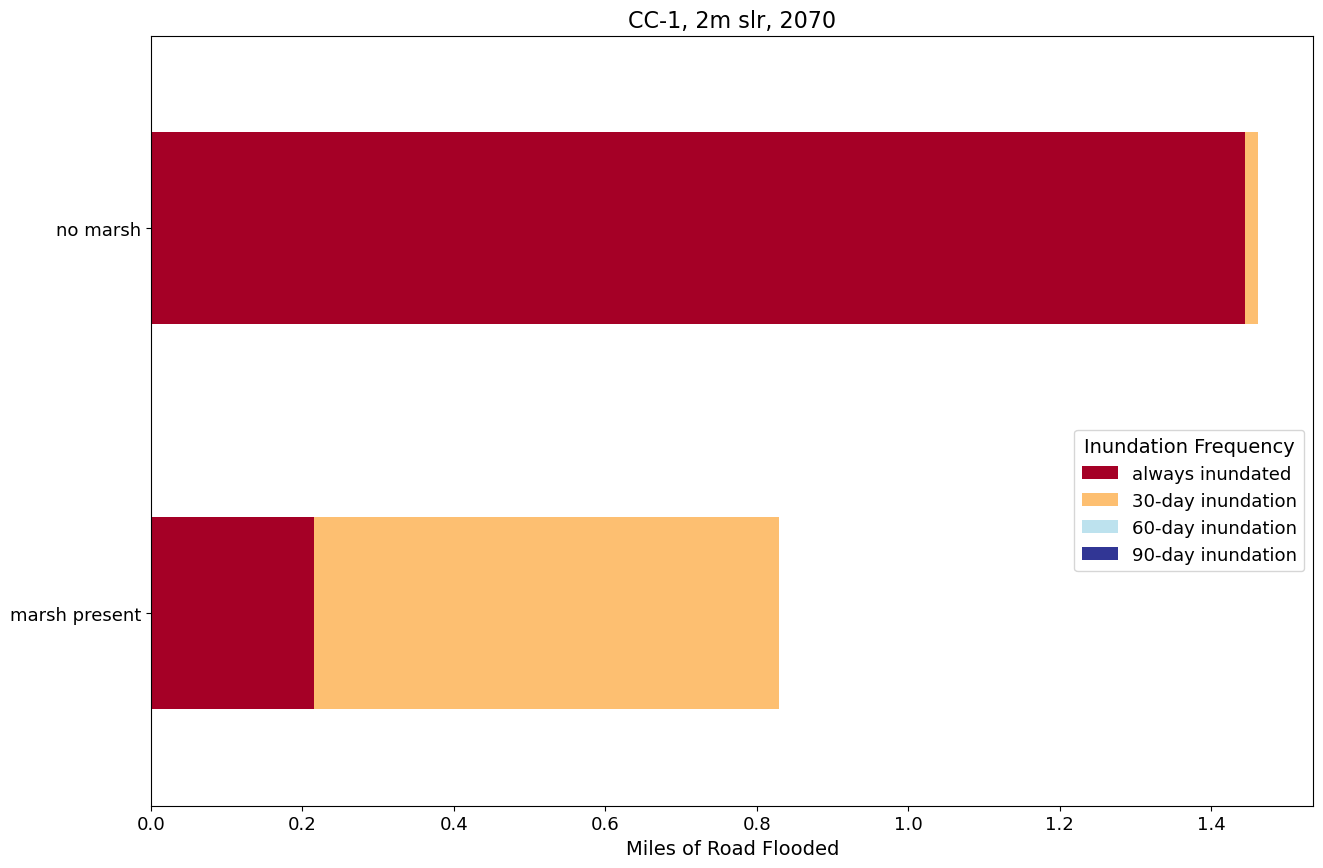

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))
pivoted_df.iloc[:, order_idxs].plot(ax=ax, kind="barh", 
                                             stacked=True, cmap="RdYlBu",
                                             ylabel=''
                                             )
plt.title("CC-1, 2m slr, 2070", fontsize=16)
plt.xlabel('Miles of Road Flooded', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
legend = plt.legend(title = "Inundation Frequency", fontsize=13, bbox_to_anchor = (1,0.5))
legend.get_title().set_fontsize('14')
ax

In [22]:
fig.savefig(CC1_OUTPUT + "cc1_2slr_70_roads_no_storm.png", dpi=350, bbox_inches="tight")